# Characterising the required end effector force

In this notebook we will try to characterise the force required by the actuator to allow the monad to carry out all the movements required to move around other monads.
We will characterise this force for different sizes of monads, which are defined by the radius of the monad. To be able to do this we need to define a few assumptions:
- The shell of the monad is completely made out of a single material with constant density.
- The thickness of the plates that make up the shell increases linearly with the radius of the monad.
- The total weight of the monad is defined as 2 times the weight of its shell, this is done to accommodate for the weight of the actuators and control systems.

Let's start with setting up the environment

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math
from math import sqrt, cos, sin, acos, asin, atan, pi
from matplotlib import collections as mc
import numpy as np

## Defining the monad variables

All the variables are stored in the Monad class and use the SI units and are linked to the radius of the monad (distance between 2 parallel faces)

In [4]:
class Monad:
    def __init__(self, radius = 0.075, density = 1.15e3) -> None:
        self.radius = radius
        self.density = density
        self.n_faces = 18
        self.n_links = 24
        self.face_length = (2 * self.radius) / (3 * sqrt(2) - 1)
        self.link_length = self.radius * ((2 - sqrt(2)) / (3 * sqrt(2) - 1))
        self.thickness = self.radius / 50
        self.link_width = self.face_length / 2
        self.face_volume = self.face_length ** 2 * self.thickness
        self.link_volume = self.link_length * self.link_width * self.thickness
        self.mass = (self.face_volume * self.n_faces + self.link_volume * self.n_links) * self.density * 2

    def __str__(self):
        return f"Radius = {self.radius*1000} mm, Density = {self.density} Kg/m3\nFace length = {self.face_length*1000} mm, Link length = {self.link_length*1000}mm\nMonad mass = {self.mass} KG"

    def inverse_kinematics(self, piston_extension):
        x = self.face_length
        y = self.face_length*piston_extension-self.link_length
        a1 = self.face_length
        a2 = self.link_length
        q2 = acos((x*x+y*y-a1*a1-a2*a2)/(2*a1*a2))
        q1 = atan(y/x)+atan(a2*sin(q2)/(a1+a2*cos(q2)))
        return q1,q1-q2,x,y+self.link_length

test_monad = Monad()
print(test_monad)

Radius = 75.0 mm, Density = 1150.0 Kg/m3
Face length = 46.258594298111326 mm, Link length = 13.548828581759444mm
Monad mass = 0.1588325938872939 KG


Now we have the main physical characteristics of the Monad and while we could use it to model the entire device, because of the many simmetries we can simplify our work by only modelling one of the latching faces, show in the diagram below.

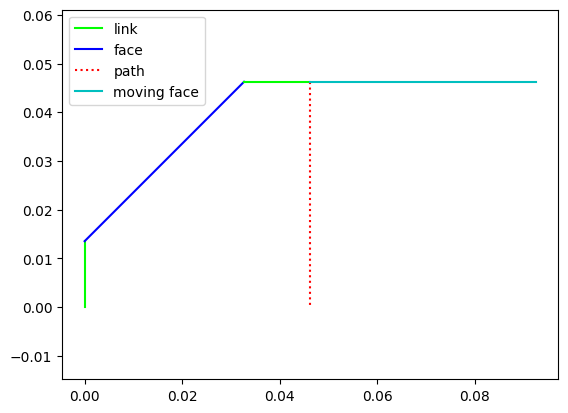

In [5]:
link_fixed = np.array([[0,0],[0,test_monad.link_length]])
face = np.array([[0,test_monad.link_length],[test_monad.face_length/sqrt(2),test_monad.face_length]])
link = np.array([[test_monad.face_length/sqrt(2),test_monad.face_length],[test_monad.face_length,test_monad.face_length]])
face_actuated = np.array([[test_monad.face_length,test_monad.face_length],[test_monad.face_length+test_monad.face_length,test_monad.face_length]])
piston = np.array([[test_monad.face_length,test_monad.face_length],[test_monad.face_length,0]])

figure = plt.figure()
ax = figure.add_subplot()
ax.plot(link_fixed[:,0], link_fixed[:,1],'lime', label='link')
ax.plot(face[:,0],face[:,1],'b', label='face')
ax.plot(link[:,0], link[:,1],'lime')
ax.plot(piston[:,0],piston[:,1], 'r', label='path', linestyle='dotted')
ax.plot(face_actuated[:,0], face_actuated[:,1], 'c', label='moving face')
ax.axis('equal')
ax.legend()


Assuming the top face is being pulled down, because it is prismatically constrained (will only move up and down) the end of the top link will move along the dotted line. The bottom link not move in this scenario and, therefore, we only have to calculate the angles of the face and top link, which can be done using the same equations as the inverse kinematics for a scara arm.

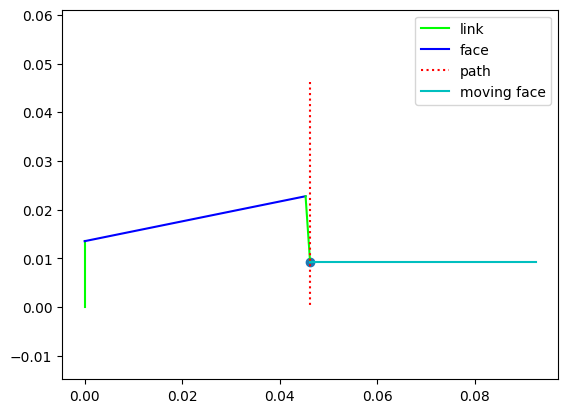

In [6]:
q1,q2,x,y = test_monad.inverse_kinematics(0.2)

face_origin = np.array([0,test_monad.link_length])
link_origin = np.add(face_origin, [test_monad.face_length*cos(q1),test_monad.face_length*sin(q1)])
piston_end = np.add(link_origin, [test_monad.link_length*cos(q2),test_monad.link_length*sin(q2)])

link_fixed = np.array([[0,0],face_origin])
face = np.array([face_origin,link_origin])
link = np.array([link_origin,piston_end])
face_actuated = np.array([piston_end,[test_monad.face_length+test_monad.face_length,test_monad.link_length+test_monad.face_length*sin(q1)+test_monad.link_length*sin(q2)]])
piston = np.array([[test_monad.face_length,test_monad.face_length],[test_monad.face_length,0]])

figure = plt.figure()
ax1 = figure.add_subplot()
ax1.plot(link_fixed[:,0], link_fixed[:,1],'lime', label='link')
ax1.plot(face[:,0],face[:,1],'b', label='face')
ax1.plot(link[:,0], link[:,1],'lime')
ax1.plot(piston[:,0],piston[:,1], 'r', label='path', linestyle='dotted')
ax1.plot(face_actuated[:,0], face_actuated[:,1], 'c', label='moving face')
ax1.axis('equal')
ax1.scatter(x,y)
ax1.legend()

<AxesSubplot: >

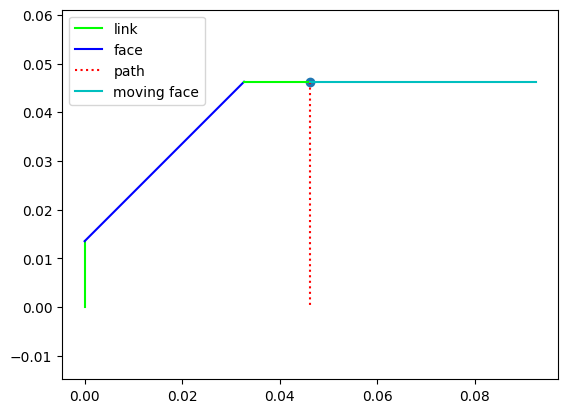

In [7]:
def draw_monad_quarter(monad, piston, figure):
    q1,q2,x,y = monad.inverse_kinematics(piston)

    face_origin = np.array([0,monad.link_length])
    link_origin = np.add(face_origin, [monad.face_length*cos(q1),monad.face_length*sin(q1)])
    piston_end = np.add(link_origin, [monad.link_length*cos(q2),monad.link_length*sin(q2)])

    link_fixed = np.array([[0,0],face_origin])
    face = np.array([face_origin,link_origin])
    link = np.array([link_origin,piston_end])
    face_actuated = np.array([piston_end,[monad.face_length+monad.face_length,monad.link_length+monad.face_length*sin(q1)+monad.link_length*sin(q2)]])
    piston = np.array([[monad.face_length,monad.face_length],[monad.face_length,0]])
    
    ax = figure.add_subplot()
    ax.plot(link_fixed[:,0], link_fixed[:,1],'lime', label='link')
    ax.plot(face[:,0],face[:,1],'b', label='face')
    ax.plot(link[:,0], link[:,1],'lime')
    ax.plot(piston[:,0],piston[:,1], 'r', label='path', linestyle='dotted')
    ax.plot(face_actuated[:,0], face_actuated[:,1], 'c', label='moving face')
    ax.axis('equal')
    ax.scatter(x,y)
    ax.legend(loc='upper left')

    return ax

test_fig = plt.figure()

draw_monad_quarter(test_monad, 1, test_fig)

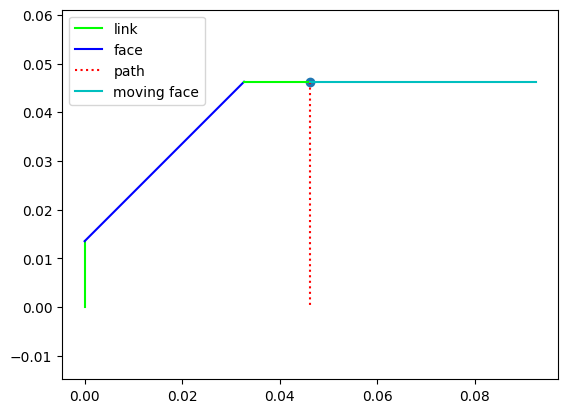

In [8]:
anim_fig = plt.figure()

def anim_update(i):

    anim_fig.clear()
    draw_monad_quarter(test_monad, abs(100-i)/100, anim_fig)

anim = animation.FuncAnimation(anim_fig, anim_update,200)
writergif = animation.PillowWriter(fps=24)
#anim.save("anim_test.gif", writer=writergif)

In [9]:
steps = 100
angle_extension = np.empty([steps,3])

for i in range(steps):
    ext = i/steps
    q,w = test_monad.inverse_kinematics(ext)[0:2]
    angle_extension[i] = np.array([ext, q, w])

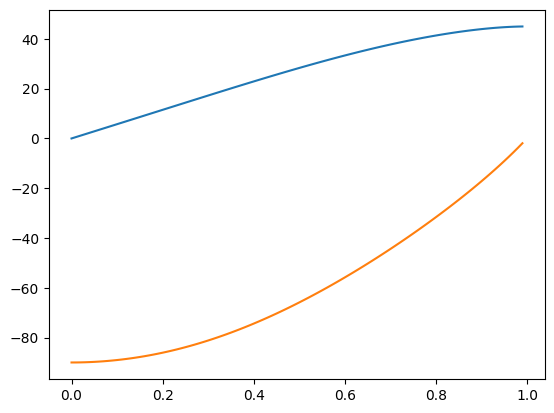

In [10]:
plt.plot(angle_extension[:,0],np.rad2deg(angle_extension[:,1]))
plt.plot(angle_extension[:,0],np.rad2deg(angle_extension[:,2]))


In [11]:
gravity = 9.8

monad_weight = test_monad.mass * gravity

extension_torque = np.empty([steps, 2])


for i,datum in enumerate(angle_extension):
    r = test_monad.radius
    f2 = test_monad.face_length/2
    q1 = datum[1]
    alpha = q1 + atan(r/f2)
    lever = cos(alpha)*sqrt(r*r+f2*f2)
    extension_torque[i] = np.array([datum[0], lever *monad_weight])

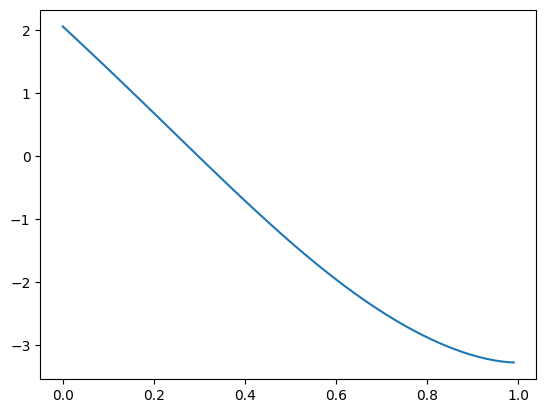

In [12]:
plt.plot(extension_torque[:,0],np.rad2deg(extension_torque[:,1]))

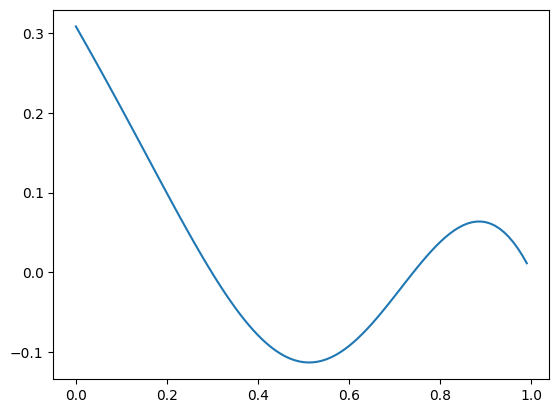

In [13]:
extension_piston_force = np.empty(steps)

for i,datum in enumerate(angle_extension):
    r = test_monad.radius
    f2 = test_monad.face_length/2
    a1 = datum[1]
    a2 = datum[2]
    alpha = a1 + atan(r/f2)
    lever = cos(alpha)*sqrt(r*r+f2*f2)
    joint_torque = lever*monad_weight
    force_end_face = joint_torque/r
    f_link = sin(a1+a2)*force_end_face
    f_piston = sin(a2)*f_link
    extension_piston_force[i] = f_piston

plt.plot(extension_torque[:,0],np.divide(extension_piston_force,monad_weight))

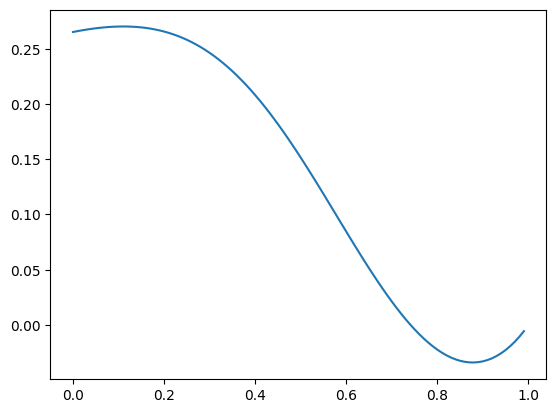

In [18]:
extension_piston_force_lateral = np.empty(steps)

for i,datum in enumerate(angle_extension):
    r = test_monad.radius
    f2 = test_monad.face_length/2
    a1 = datum[1]
    a2 = datum[2]
    alpha = a1 + atan(r/f2)
    lever = -sin(alpha)*sqrt(r*r+f2*f2)
    joint_torque = lever*monad_weight
    force_end_face = joint_torque/r
    f_link = sin(a1+a2)*force_end_face
    f_piston = sin(a2)*f_link
    extension_piston_force[i] = f_piston

plt.plot(extension_torque[:,0],np.divide(extension_piston_force_lateral,monad_weight))